In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1)

import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import os
from functools import reduce

# Training CVAE

In [4]:
img_transform = transforms.Compose([
    transforms.ToTensor()
])

# MNIST dataset
train_data = torchvision.datasets.MNIST(root='data',train=True,
                                        transform=img_transform, download=True)

test_data = torchvision.datasets.MNIST(root='data',train=False,
                                       transform=img_transform, download=True)

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters
im_size = 28
z_dim = 20
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

input_dim = im_size * im_size
hidden_dim = 256
latent_dim = 75
n_classes = 10

In [7]:
def idx2onehot(idx, n):

    assert idx.shape[1] == 1
    assert torch.max(idx).item() < n

    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx.data, 1)

    return onehot

In [8]:
class Encoder(nn.Module):
    ''' This the encoder part of VAE

    '''
    def __init__(self, input_dim, hidden_dim, latent_dim, n_classes):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            latent_dim: A integer indicating the latent size.
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.linear = nn.Linear(input_dim + n_classes, hidden_dim)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        # x is of shape [batch_size, input_dim + n_classes]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]

        # latent parameters
        mean = self.mu(hidden)
        # mean is of shape [batch_size, latent_dim]
        log_var = self.var(hidden)
        # log_var is of shape [batch_size, latent_dim]

        return mean, log_var


In [9]:
class Decoder(nn.Module):
    ''' This the decoder part of VAE

    '''
    def __init__(self, latent_dim, hidden_dim, output_dim, n_classes):
        '''
        Args:
            latent_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the size of output (in case of MNIST 28 * 28).
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.latent_to_hidden = nn.Linear(latent_dim + n_classes, hidden_dim)
        self.hidden_to_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x is of shape [batch_size, latent_dim + num_classes]
        x = F.relu(self.latent_to_hidden(x))
        # x is of shape [batch_size, hidden_dim]
        generated_x = F.sigmoid(self.hidden_to_out(x))
        # x is of shape [batch_size, output_dim]

        return generated_x


In [10]:
class CVAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.

    '''
    def __init__(self, input_dim, hidden_dim, latent_dim, n_classes):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            latent_dim: A integer indicating the latent size.
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, n_classes)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, n_classes)

    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)
        # encode
        z_mu, z_var = self.encoder(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        z = torch.cat((x_sample, y), dim=1)

        # decode
        generated_x = self.decoder(z)

        return generated_x, z_mu, z_var



In [12]:
# model
model = CVAE(input_dim, hidden_dim, latent_dim, n_classes)
model.to(device)
#optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
def calculate_loss(x, reconstructed_x, mean, log_var):
    # reconstruction loss
    RCL = F.binary_cross_entropy(reconstructed_x, x, size_average=False)
    # kl divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return RCL + KLD


In [14]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, (x, y) in enumerate(train_loader):
        # reshape the data into [batch_size, 784]
        x = x.view(-1, 28 * 28)
        x = x.to(device)

        # convert y into one-hot encoding
        y = idx2onehot(y.view(-1, 1), 10)
        
        y = y.to(device)
        
        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        reconstructed_x, z_mu, z_var = model(x, y)

        # loss
        loss = calculate_loss(x, reconstructed_x, z_mu, z_var)

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()
        
        break

    return train_loss


In [15]:
def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            # reshape the data
            x = x.view(-1, 28 * 28)
            x = x.to(device)

            # convert y into one-hot encoding
            y = idx2onehot(y.view(-1, 1), 10)
            y = y.to(device)
            
            # forward pass
            reconstructed_x, z_mu, z_var = model(x, y)

            # loss
            loss = calculate_loss(x, reconstructed_x, z_mu, z_var)
            test_loss += loss.item()

    return test_loss



In [18]:
for e in range(1000):

    train_loss = train()
    test_loss = test()

    train_loss /= len(train_data)
    test_loss /= len(test_data)
    
    if e%100 == 0:
        print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

Epoch 0, Train Loss: 0.44, Test Loss: 204.30
Epoch 100, Train Loss: 0.36, Test Loss: 168.58
Epoch 200, Train Loss: 0.34, Test Loss: 156.56
Epoch 300, Train Loss: 0.31, Test Loss: 146.72
Epoch 400, Train Loss: 0.30, Test Loss: 140.10
Epoch 500, Train Loss: 0.29, Test Loss: 135.39
Epoch 600, Train Loss: 0.29, Test Loss: 130.70
Epoch 700, Train Loss: 0.28, Test Loss: 127.41
Epoch 800, Train Loss: 0.27, Test Loss: 123.94
Epoch 900, Train Loss: 0.27, Test Loss: 121.36


# Sample from latent distribution 

In [174]:
test_data = torchvision.datasets.MNIST(root='data',train=False,
                                       transform=img_transform, download=True)

ind_ones = torch.where((test_data.targets == 1))
labels_ones = test_data.targets[ind_ones]
data_ones = test_data.data[ind_ones].float()
ones_dataset = torch.utils.data.TensorDataset(data_ones, labels_ones)
ones_loader = torch.utils.data.DataLoader(dataset=ones_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

ind_sevens = torch.where((test_data.targets == 7))
labels_sevens = test_data.targets[ind_sevens]
data_sevens = test_data.data[ind_sevens].float()
sevens_dataset = torch.utils.data.TensorDataset(data_sevens, labels_sevens)
sevens_loader = torch.utils.data.DataLoader(dataset=sevens_dataset,
                                            batch_size=batch_size, 
                                            shuffle=False)

In [181]:
def return_batch_data_from_loader(data_loader):
    list_imgs = []
    list_labels = []
    with torch.no_grad():
        for x, y in ones_loader:
            x = x.view(-1, 28 * 28)
            x = x.to(device)
            y = idx2onehot(y.view(-1, 1), 10)
            y = y.to(device)

            list_imgs.append(x)
            list_labels.append(y)    

    return list_imgs, list_labels

In [182]:
list_imgs_ones, list_labels_ones = return_data_from_loader(ones_loader)
list_imgs_sevens, list_labels_sevens = return_data_from_loader(sevens_loader)

In [204]:
def return_latent_parameters(model, batch_data, labels):
    model.eval()
    paramterers = {}
    _, z_mu, z_var = model(batch_data, labels)
    
    std = torch.exp(z_var / 2)
    eps = torch.randn_like(std)
    
    paramterers['mu'] = z_mu
    paramterers['std'] = std
    paramterers['eps'] = eps
     
    return z_mu, std, eps

In [195]:
ones_for_normal = list_imgs_ones[:-3]
ones_labels_for_normal = list_labels_ones[:-3]

ones_for_normal_starts = ones_for_normal[:3]
ones_labels_for_normal_starts = ones_labels_for_normal[:3]

ones_for_normal_ends =  ones_for_normal[3:]
ones_labels_for_normal_ends = ones_labels_for_normal[3:]

ones_for_anomaly = list_imgs_ones[-3:]
ones_labels_for_anomaly = list_labels_ones[-3:]

In [192]:
sevens_for_anomaly = list_imgs_sevens[:2]
sevens_labels_for_anomaly = list_labels_sevens[:2]

In [291]:
def interpolate_numbers(y1, y2, x):
    return (y2 - y1)*x + y1

In [ ]:
seq_len = 128
ts = torch.linspace(0, 1, seq_len)
imgs_series = []

for i in range(3):
    
    starts = ones_for_normal_starts[i]    
    ends = ones_for_normal_ends[i]
    labels_ones = ones_labels_for_normal[0][0]
    
    z_mu_1, std_1, eps_1 = return_latent_parameters(model, starts, starts_labels)
    z_mu_2, std_2, eps_2 = return_latent_parameters(model, ends, ends_labels)
    
    for j in range(batch_size):
        
        z_mu_1_i = z_mu_1[i]
        z_mu_2_i = z_mu_2[i]
        std_1_i = std_1[i]
        std_2_i = std_2[i]
        eps_1_i = eps_1[i]
        eps_2_i = eps_2[i]
        
        images_serie = []
        
        for k in range(seq_len):
            
            coef = ts[k]
            z_mu_new = interpolate_numbers(z_mu_1_i, z_mu_2_i, coef)
            std_new = interpolate_numbers(std_1_i, std_2_i, coef)
            eps_new = interpolate_numbers(eps_1_i, eps_2_i, coef)
            
            x_sample = z_mu_new.add(std_new.mul(eps_new))
            
            z_new = torch.cat((x_sample, labels_ones))
            
            images_serie.append(model.decoder(z_new))
            
            plt.imshow(model.decoder(z_new).view(28,28).detach().cpu().numpy())
    
        imgs_series.append(images_serie)

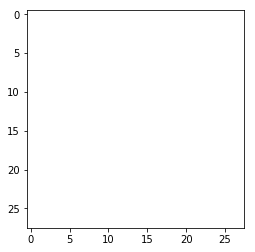

In [335]:
from matplotlib import pyplot as plt
from celluloid import Camera

fig = plt.figure()
camera = Camera(fig)

for ind in range(seq_len):
    plt.imshow(imgs_series[-1][ind].view(28,28).detach().cpu().numpy())
    camera.snap()

animation = camera.animate()
animation.save('animation2.gif', writer = 'imagemagick')